In [1]:
import dataset
import model

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T

torch.cuda.is_available()

True

In [2]:
DEVICE = torch.device('cuda')

In [3]:
# encoder = 

In [4]:
encoder.requires_grad_(False)
sum(p.numel() for p in encoder.parameters() if p.requires_grad)

0

In [5]:
rrc = T.RandomResizedCrop(256, scale=(0.5, 1.0), ratio=(1,1))

def dual_crop(img, depth):
    img = T.functional.to_tensor(img)
    crop = rrc.get_params(img, rrc.scale, rrc.ratio)
    img = T.functional.resized_crop(img, *crop, rrc.size, rrc.interpolation, antialias=rrc.antialias)
    depth = T.functional.resized_crop(depth, *crop, rrc.size, rrc.interpolation, antialias=rrc.antialias)
#     depth = T.functional.resize(depth, 32)
    return img, depth

train_data = dataset.DepthDataset('/data/cse455/train', dual_transform=dual_crop)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=8)

In [6]:
x, y = next(iter(train_loader))
x.shape, y.shape, y.min(), y.float().mean(), y.max()

(torch.Size([32, 3, 256, 256]),
 torch.Size([32, 1, 256, 256]),
 tensor(0.),
 tensor(7.6750),
 tensor(251.3781))

In [11]:
def convert_depth(raw):
    depth = T.functional.resize(raw, 32)
    for i in range(len(depth)):
        depth[i] -= depth[i].min()
        depth[i] /= (depth[i].max() + 0.001)
    
#     return torch.where(depth==0, 100, depth)
#     return (depth+1).log()
    return depth

In [14]:
# encoder = convnext.features.to(DEVICE)
encoder = T.Resize(32).to(DEVICE)
# linear_probe = nn.Conv2d(1024, 1, 1).to(DEVICE)
linear_probe = nn.Conv2d(3, 1, 1).to(DEVICE)

In [15]:
epochs = 1

log = []

optimizer = torch.optim.Adam(linear_probe.parameters(), lr=1e-4, )
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader))
criterion = nn.MSELoss()
# criterion = nn.L1Loss()

for epoch in (bar_e := tqdm(range(epochs))):
    for X, raw in (bar_b := tqdm(train_loader)):
        X = X.to(DEVICE)
        raw = raw.to(DEVICE)
        
        y = convert_depth(raw)
        
        optimizer.zero_grad()
        
        pred = linear_probe(encoder(X))
        pred = torch.where(y==0, y, pred)
        
        loss = criterion(pred, y)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        bar_b.set_postfix(loss=loss.item())
        log.append(loss.item())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/796 [00:00<?, ?it/s]

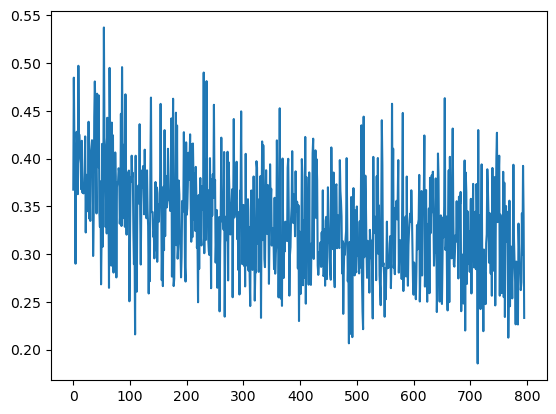

In [16]:
# no-model
plt.plot(log)

In [17]:
encoder = encoder.to('cpu')
linear_probe = linear_probe.to('cpu')

In [18]:
x, y = next(iter(train_loader))
d = convert_depth(y)
d_ = linear_probe(encoder(x)).detach()

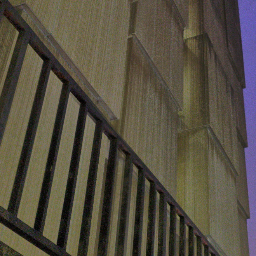

In [32]:
i = 7
T.functional.to_pil_image(x[i])

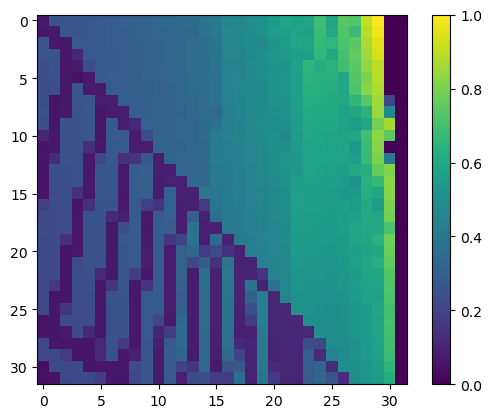

In [33]:
plt.imshow(d[i,0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

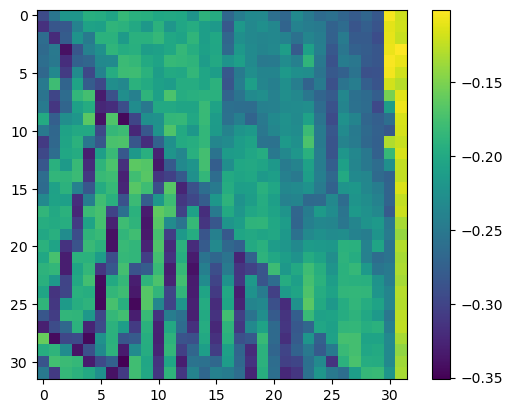

In [34]:
plt.imshow(d_[i,0].detach(), )
plt.colorbar()
plt.show()

In [6]:
encoder = encoder.to('cpu')
decoder = decoder.to('cpu')